#### Лабораторная работа № 2 «Детектирование объектов на изображениях с помощью глубоких нейронных сетей»

In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/stanfordu/street-view-house-numbers")
od.download("https://www.kaggle.com/datasets/konradb/text-recognition-total-text-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading street-view-house-numbers.zip to ./street-view-house-numbers


100%|██████████| 2.50G/2.50G [08:20<00:00, 5.36MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading text-recognition-total-text-dataset.zip to ./text-recognition-total-text-dataset


100%|██████████| 413M/413M [01:26<00:00, 5.02MB/s] 


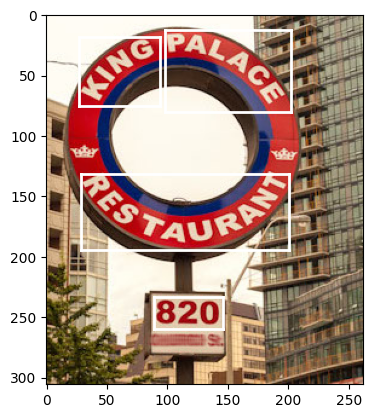

In [18]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_im_with_box(im_name):
    mat = scipy.io.loadmat(
        "text-recognition-total-text-dataset/TT_new_train_GT/Train/gt_"
        + str(im_name)
        + ".mat"
    )


    img = mpimg.imread(
        "text-recognition-total-text-dataset/totaltext/Images/Train/"
        + str(im_name)
        + ".jpg"
    )

    for i in range(len(mat['gt'])):
        x = mat['gt'][i][1][0]
        y = mat['gt'][i][3][0]
        x1 = max(x)
        x2 = min(x)
        y1 = max(y)
        y2 = min(y)
        plt.plot([x1, x1], [y1, y2],[x2, x2], [y1, y2],[x1, x2], [y1, y1],[x1, x2], [y2, y2], color="white", linewidth=2)
    plt.imshow(img)
    plt.show()

show_im_with_box("img107")

In [ ]:
import torch
from torchvision import transforms, datasets, models

def generate_target(file_mat):
    mat = scipy.io.loadmat(file_mat)
    boxes = list()
    labels = list()
    for i in range(len(mat['gt'])):
        x = mat['gt'][i][1][0]
        y = mat['gt'][i][3][0]
        x1 = max(x) + 1
        x2 = min(x)
        y1 = max(y) + 1
        y2 = min(y)
        boxes.append([x2, y2, x1, y1])
        labels.append(1)

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {"boxes": boxes, "labels": labels}

    return target


class MaskDataset(object):
    def __init__(self, transforms, path, path_mat):
        self.transforms = transforms
        self.path = path
        self.path_mat = path_mat
        self.imgs = list(sorted(os.listdir(self.path)))
        self.mats = list(sorted(os.listdir(self.path_mat)))

    def __getitem__(self, idx):
        file_image = "text-recognition-total-text-dataset/totaltext/Images/Train/" + str(self.imgs[idx])
        file_mat = "text-recognition-total-text-dataset/TT_new_train_GT/Train/" + str(self.mats[idx])

        img = Image.open(file_image).convert("RGB")
        target = generate_target(file_mat)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(
    data_transform,
    "text-recognition-total-text-dataset/totaltext/Images/Train/",
    "text-recognition-total-text-dataset/TT_new_train_GT/Train/"
)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
from tqdm import tqdm

num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for imgs, annotations in tqdm(data_loader):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, loss : {epoch_loss}')

In [ ]:
import mat73
mat = mat73.loadmat("street-view-house-numbers/train_digitStruct.mat")

In [22]:
def generate_target_for_number(mat):
    boxes = list()
    labels = list()
    if not isinstance(mat['height'], list):
        h = mat['height']
        w = mat['width']
        x1 = mat['left'].item()
        y1 = mat['top'].item()
        x2 = x1 + w
        y2 = y1 + h
        boxes.append([x1, y1, x2, y2])
        labels.append(1)
    else:
      length = len(mat['height'])
      for i in range(length):
          h = mat['height'][i]
          w = mat['width'][i]
          x1 = mat['left'][i].item()
          y1 = mat['top'][i].item()
          x2 = x1 + w
          y2 = y1 + h
          boxes.append([x1, y1, x2, y2])
          labels.append(1)

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {"boxes": boxes, "labels": labels}

    return target

class MaskDatasetForNumbers(object):
    def __init__(self, transforms, mat):
        self.transforms = transforms
        self.path = "street-view-house-numbers/train/train/"
        self.mats = mat
        self.imgs = list()
        for t in list(sorted(os.listdir(self.path))):
            if t.endswith('.png'):
              self.imgs.append(t)

    def __getitem__(self, idx):
        file_image = "street-view-house-numbers/train/train/" + str(self.imgs[idx])

        img = Image.open(file_image).convert("RGB")
        target = generate_target_for_number(self.mats[idx])

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset_number = MaskDatasetForNumbers(
    data_transform, mat['digitStruct']['bbox']
)

data_loader_number = torch.utils.data.DataLoader(dataset_number, batch_size=8, collate_fn=collate_fn)

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for imgs, annotations in tqdm(data_loader_number):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, loss : {epoch_loss}')

In [ ]:
torch.save(model.state_dict(),f'model_20.pt')

In [2]:
import torch
from torchvision import transforms, datasets, models
import os
from PIL import Image

model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.load_state_dict(torch.load(f'model_20.pt', map_location=torch.device('cpu')))

/Users/egor.bazhenov/PycharmProjects/GANs/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/egor.bazhenov/PycharmProjects/GANs/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

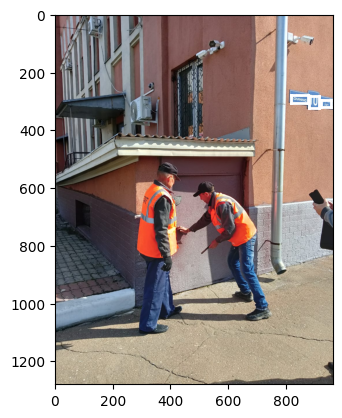

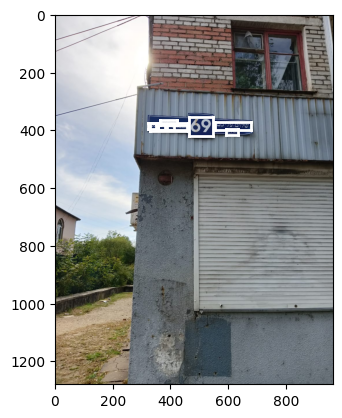

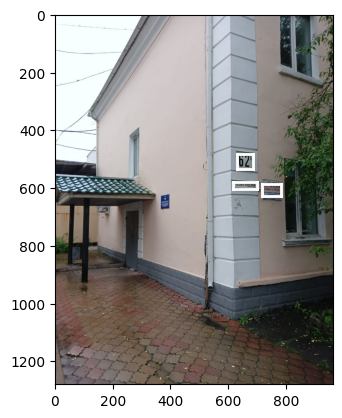

In [39]:
def show_im_with_boxes(path, list_coor):
    img = mpimg.imread(path)
    for i in range(len(list_coor)):
        x1 = list_coor[i][0].item()
        x2 = list_coor[i][2].item()
        y1 = list_coor[i][1].item()
        y2 = list_coor[i][3].item()
        plt.plot([x1, x1], [y1, y2],[x2, x2], [y1, y2],[x1, x2], [y1, y1],[x1, x2], [y2, y2], color="white", linewidth=2)
    plt.imshow(img)
    plt.show()

def make_prediction(model, path, threshold):
    img = Image.open(path).convert("RGB")
    convert_tensor = transforms.Compose([
        transforms.ToTensor()
    ])
    img = convert_tensor(img).clone().to(device)
    model.eval()
    l = list()
    l.append(img)
    preds = model(l)
    for id in range(len(preds)) :
        idx_list = []
        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

with torch.no_grad():
    for i in range(1, 4):
        file_path = "test/" + str(i) + ".jpg"
        pred = make_prediction(model, file_path, 0.5)
        show_im_with_boxes(file_path, pred[0]['boxes'])

In [21]:
import mat73
mat = mat73.loadmat("street-view-house-numbers/test_digitStruct.mat")

In [46]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision import transforms
import torch
import statistics


def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    recall = interArea / float(boxAArea)
    precision = interArea / float(boxBArea)

    return [iou, recall, precision]


def culc_iou(preds, targets):
    preds_boxes_np = preds["boxes"].numpy()
    targets_boxes_np = targets["boxes"].numpy()
    ious = list()
    recalls = list()
    precisions = list()
    for idx1 in range(len(targets_boxes_np)):
        best_iou = 0
        best_recall = 0
        best_precision = 0
        for idx2 in range(len(preds_boxes_np)):
            metrics = bb_intersection_over_union(preds_boxes_np[idx1], targets_boxes_np[idx2])
            if metrics[0] > best_iou:
                best_iou = metrics[0]
                best_recall = metrics[1]
                best_precision = metrics[2]
        ious.append(best_iou)
        recalls.append(best_recall)
        precisions.append(best_precision)
    return [statistics.mean(ious), statistics.mean(recalls), statistics.mean(precisions)]


def culc_mean_iou(preds, targets):
    ious = list()
    recalls = list()
    precisions = list()
    for (pred, target) in zip(preds, targets):
        metrics = culc_iou(pred, target)
        ious.append(metrics[0])
        recalls.append(metrics[1])
        precisions.append(metrics[2])
    return {
        'iou': statistics.mean(ious),
        'recall': statistics.mean(recalls),
        'precision': statistics.mean(precisions)
    }


def make_prediction_with_img(model, img):
    model.eval()
    l = list()
    l.append(img)
    preds = model(l)
    return preds


metric = MeanAveragePrecision()

dataset_number = MaskDatasetForNumbers(
    data_transform, mat['digitStruct']['bbox']
)

predictions = list()
targets = list()
for img, target in dataset_number:
    targets.append(target)
    with torch.no_grad():
        pred = make_prediction_with_img(model, img)
        predictions.append(pred[0])
    break

metric.update(predictions, targets)
metrics = culc_mean_iou(predictions, targets)
print("map metric : " + str(metric.compute()['map'].item()))
print("iou metric : " + str(metrics['iou']))
print("recall metric : " + str(metrics['recall']))
print("precision metric : " + str(metrics['precision']))

map metric : 0.508044
iou metric : 0.621819
recall metric : 0.563694
precision metric : 0.600787
